In [70]:
import sys
import shutil
import os
import numpy as np
import math
from scipy import ndimage
import matplotlib.pyplot as plt
import torch as th
from skimage import morphology, filters
from scipy.ndimage import gaussian_filter
from dipy.io.image import load_nifti, save_nifti

In [110]:
def _smoothmax(vol_list,alpha=0.01,multiplier=1.0):

        vol_out = np.zeros_like(vol_list[0])

        for i in range(0,vol_list[0].shape[0]):
            for j in range(0,vol_list[0].shape[1]):
                for k in range(0,vol_list[0].shape[2]):
                    numer=0
                    denom=0
                    for ind in range(0,len(vol_list)):
                        vol=vol_list[ind]
                        p = vol[i,j,k]
                        numer += p*math.exp(alpha*p)
                        denom += math.exp(alpha*p)

                    vol_out[i,j,k] = numer/denom
        return vol_out*multiplier
    
    
    
def _vectorized_soft(m, alpha, beta, shift=1.0):
        return 1 + (1-alpha)*(np.square(np.tanh(beta*(m-shift)))-1)
    

    
def _return_matted_transform(vol, alpha=2.0, beta=1.1, use_mask=True):
    if use_mask:
        #vol_blurred = ndimage.gaussian_filter(vol, sigma=0.2)
        norm_transform = ndimage.gaussian_filter(ndimage.distance_transform_edt(vol), sigma=1.0)
        inv_transform = ndimage.gaussian_filter(ndimage.distance_transform_edt(1 - vol), sigma=1.0)
        return _vectorized_soft(norm_transform + inv_transform, alpha, beta)
    else:
        return vol

In [102]:
t2_vol_path = "/Users/markolchanyi/Desktop/Edlow_Brown/Projects/Atlases/CRSEG_atlas/T2_0.5mm.mgz"
scp_vol_path = "/Users/markolchanyi/Desktop/Edlow_Brown/Projects/Atlases/CRSEG_atlas/superstructures_v2/SCP_ROSTRAL.mgz"
ctg_vol_path = "/Users/markolchanyi/Desktop/Edlow_Brown/Projects/Atlases/CRSEG_atlas/superstructures_v2/CTG.mgz"
rn_vol_path = "/Users/markolchanyi/Desktop/Edlow_Brown/Projects/Atlases/CRSEG_atlas/superstructures_v2/RN.mgz"

t2_vol,dummy_affine = load_nifti(t2_vol_path, return_img=False)
scp_vol,dummy_affine = load_nifti(scp_vol_path, return_img=False)
ctg_vol,dummy_affine = load_nifti(ctg_vol_path, return_img=False)
rn_vol,dummy_affine = load_nifti(rn_vol_path, return_img=False)


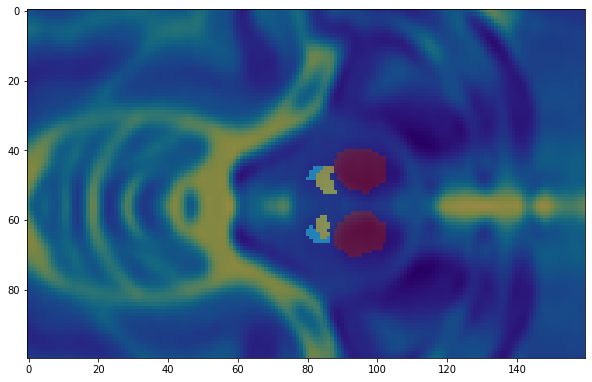

In [103]:
slice1 = 200
slice2 = 300
slice4 = 275
slice5 = 120 
slice6 = 280

all_masks_vol = scp_vol * 5
all_masks_vol[ctg_vol == 1] = 10
all_masks_vol[rn_vol > 0.5] = 15


t2_vol_slice = t2_vol[slice1:slice2,slice4,slice5:slice6]
mask_vol_slice = all_masks_vol[slice1:slice2,slice4,slice5:slice6]

# changing the size of figure to 2X2
plt.figure(figsize=(10, 10))
display(plt.imshow(t2_vol_slice, interpolation='nearest'))
display(plt.imshow(mask_vol_slice,'jet', interpolation='none', alpha=0.4))



In [135]:
mask_list = []
df_mask_list = []

rn_vol_thresholded = np.zeros_like(rn_vol) 
rn_vol_thresholded[rn_vol>0.5] = 1

mask_list.append(scp_vol[slice1:slice2,slice4-20:slice4+20,slice5:slice6])
mask_list.append(ctg_vol[slice1:slice2,slice4-20:slice4+20,slice5:slice6])
mask_list.append(rn_vol_thresholded[slice1:slice2,slice4-20:slice4+20,slice5:slice6])

for i in range(len(mask_list)):
    df_mask_list.append(_return_matted_transform(mask_list[i], alpha=20.0, beta=1.1))
    
smax_mask = _smoothmax(df_mask_list,alpha=0.15,multiplier=1.0)

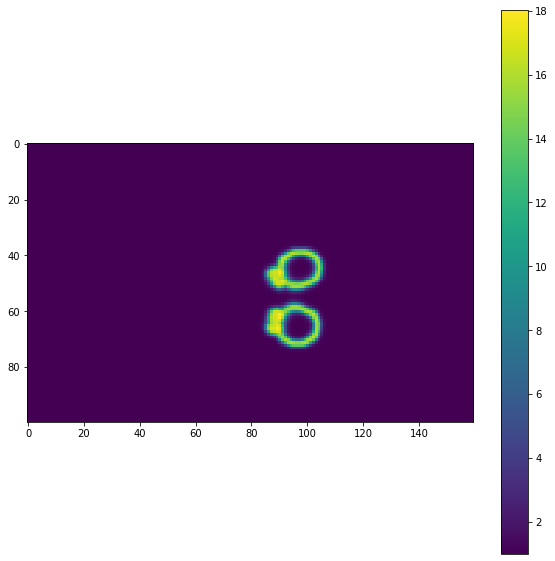

In [136]:
# changing the size of figure to 2X2
plt.figure(figsize=(10, 10))
plt.imshow(smax_mask[:,14,:], interpolation='nearest')
plt.colorbar()
plt.ion()

In [132]:

print(smax_mask[40:80,14,80:100])


[[ 1.00002848  1.00004874  1.00010048  1.00024978  1.00071053  1.00229059
   1.00860084  1.03850202  1.20094678  2.15250582  6.40101756 12.71333999
  15.74078301 16.17594225 14.73492246 11.43661973  8.21278952  6.8454456
   6.88616359  8.32509407]
 [ 1.00011543  1.00019533  1.00040306  1.00105332  1.00309896  1.00917957
   1.02736428  1.09570562  1.45013513  3.78915599 11.83744264 16.24545485
  15.88731244 12.7383472   7.81515689  4.01579708  2.40398378  1.94939034
   1.94280415  2.36452698]
 [ 1.00039059  1.00068364  1.00147326  1.00421436  1.01383813  1.04368327
   1.11923355  1.30029227  1.93884862  5.65674232 14.27729571 16.30237328
  12.82512313  6.71667377  3.07800732  1.74459018  1.31305649  1.18761474
   1.17442969  1.25672582]
 [ 1.00103398  1.00197724  1.00478087  1.0155964   1.05813389  1.2095529
   1.64900295  2.57347772  4.02265084  7.905384   14.94439409 15.48407496
   9.76631958  3.92327219  1.87965167  1.29611441  1.11428409  1.05855578
   1.04911657  1.07439265]
 [ 1.0

In [ ]:
x_array = [-4, -3, -2, -1, 0, 1, 2, 3, 4]